### 背景简介
eMaize问题要求我们以SNP作为特征，通过训练一个模型，对玉米的三个性状进行预测 <br>
接下来的教程会展示从原始数据开始，如何对数据进行转换，存取，特征选择以及回归和后续分析的整个过程。<br>
本问题最基本的目标是使用6210个样本中的前4754个样本作为训练集，预测其他样本的性状<br>

本教程使用jupyter notebook，可以让使用者获得更好的体验，方便对代码进行修改，以及对结果进行查看和分析
#### jupyter notebook基本使用指南：
一段相关的代码在同一个代码框中书写，同时按住shift与enter即可运行选中的代码框的代码<br>
仅仅按enter键具有回车的效果
##### 使用上方的编辑栏：
点击加号在两个代码框中间插入新的代码框，删除代码框点击剪刀，中止程序点击方框

In [1]:
#导入必需的库
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.random_projection import SparseRandomProjection
from scipy.sparse import load_npz, save_npz
import scipy.stats
import pandas as pd
import seaborn as sns
import sklearn
import h5py
from sklearn.metrics import r2_score
from scipy.stats.stats import pearsonr
import pickle
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from tqdm import tqdm_notebook as tqdm
from IPython.display import display, Image
%pylab inline
plt.style.use('ggplot')
from ipywidgets import interact, FloatSlider, RadioButtons,Dropdown,SelectMultiple,FloatRangeSlider
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Users/james/bioinfo_git


### 1查看原始数据
genotype：SNP数据，每个位点可能有三种情况，如AA，AT，TT  <br>
trait：共三种，trait1开花期，trait2株高，trait3产量，为连续值 <br>
原始数据中有6210个样本，每个样本SNP位点约为190万个 <br>
因为计算资源的原因，这里仅仅选取其中的5000个SNP作为示例 <br>
因为数据量的原因，结果肯定不够理想

#### 数据格式
txt存储格式不适合大数据读取的问题，对内存的占用过多 <br>
对于结构化的、能够存储为矩阵的数据，可以使用HDF5格式存取，内存占用小，读取速度快

##### 读取SNP数据，数据格式为HDF5
##### 在命令行查看数据shape的方法为：
cd至文件路径下，输入：h5ls snp_5000  <br>
若使用了新版h5py，可能出现无法打开的情况，此时输入HDF5_USE_FILE_LOCKING=FALSE h5ls snp_5000

In [3]:
#使用h5py读取5000个SNP：
with h5py.File('data/snp_5000','r') as f:
    snps = f['snp'][:]
#查看数据shape,h5py读取出的snps是一个矩阵，可以用.shape查看其shape
snps.shape

(5001, 6214)

In [4]:
#查看数据内容
#np.array(snps)

##### 读取性状数据
使用numpy/pandas均可读取性状数据并显示，这里用pandas展示，真正计算时一般用numpy

In [5]:
traits = pd.read_csv('data/pheno_emaize.txt','\t')
#仅显示前五个,4754之后的样本的性状是未知的
print(traits.head(n=5))
#numpy.array
#traits['trait1'][:4000]
print(traits)
numpy.array(traits)

       type     id pedigree    trait1    trait2    trait3
0  training  L0001  f1_X_m1 -1.746103 -0.785525 -0.331637
1  training  L0002  f2_X_m1 -1.679248 -1.569490 -2.572614
2  training  L0003  f3_X_m1 -2.748920 -0.608644 -1.108812
3  training  L0004  f4_X_m1 -2.414647 -0.672045 -1.315051
4  training  L0005  f5_X_m1 -1.879812 -0.740913 -1.879181
          type     id    pedigree    trait1    trait2    trait3
0     training  L0001     f1_X_m1 -1.746103 -0.785525 -0.331637
1     training  L0002     f2_X_m1 -1.679248 -1.569490 -2.572614
2     training  L0003     f3_X_m1 -2.748920 -0.608644 -1.108812
3     training  L0004     f4_X_m1 -2.414647 -0.672045 -1.315051
4     training  L0005     f5_X_m1 -1.879812 -0.740913 -1.879181
5     training  L0006     f6_X_m1 -2.347793 -0.401772 -1.442920
6     training  L0007     f7_X_m1 -2.013521 -0.526802 -0.688812
7     training  L0008     f8_X_m1 -2.214084 -0.691969 -1.589630
8     training  L0009     f9_X_m1 -1.879812 -0.759537 -1.872018
9     traini

array([['training', 'L0001', 'f1_X_m1', -1.74610282478836,
        -0.7855251215738208, -0.33163696544539506],
       ['training', 'L0002', 'f2_X_m1', -1.67924837319023,
        -1.5694898694514998, -2.57261413504835],
       ['training', 'L0003', 'f3_X_m1', -2.7489195987604504,
        -0.608643883224438, -1.10881183080429],
       ...,
       ['test', 'L6208', 'f205_X_m25', nan, nan, nan],
       ['test', 'L6209', 'f206_X_m25', nan, nan, nan],
       ['test', 'L6210', 'f207_X_m25', nan, nan, nan]], dtype=object)

In [6]:
#pandas dataframe也可查看shape
print (traits.shape)

(6210, 6)


##### 查看性状的分布情况

Text(0.5,1,u'Normalized Trait3: Yield')

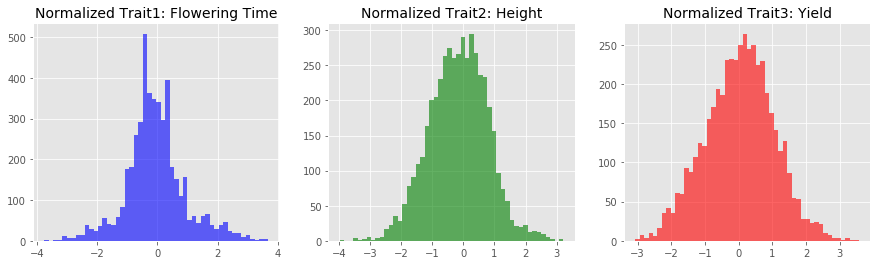

In [7]:
trait1 = np.array(traits['trait1'])[:4754]
trait2 = np.array(traits['trait2'])[:4754]
trait3 = np.array(traits['trait3'])[:4754]
fig, ax = plt.subplots(1,3, figsize=(15,4))
ax[0].hist(trait1,bins = 50,color='b',alpha=0.6)
ax[0].set_title('Normalized Trait1: Flowering Time',fontsize=14)
ax[1].hist(trait2,bins = 50,color='g',alpha=0.6)
ax[1].set_title('Normalized Trait2: Height',fontsize=14)               
ax[2].hist(trait3,bins = 50,color='r',alpha=0.6)
ax[2].set_title('Normalized Trait3: Yield',fontsize=14)

In [8]:
trait1.shape

(4754,)

In [9]:
phenodatatable = pd.concat((pd.DataFrame(np.concatenate((np.repeat('Flowering Time',trait1.shape[0]),np.repeat('Height',trait1.shape[0]),
                np.repeat('Yiled',trait1.shape[0]))),columns=['trait']),pd.DataFrame(np.concatenate((trait1,trait2,trait3)),
             columns=['value'])),axis=1)
phenodatatable.head()

,trait,value
0,Flowering Time,-1.746103
1,Flowering Time,-1.679248
2,Flowering Time,-2.748920
3,Flowering Time,-2.414647
4,Flowering Time,-1.879812


##### violin plot of normalized traits

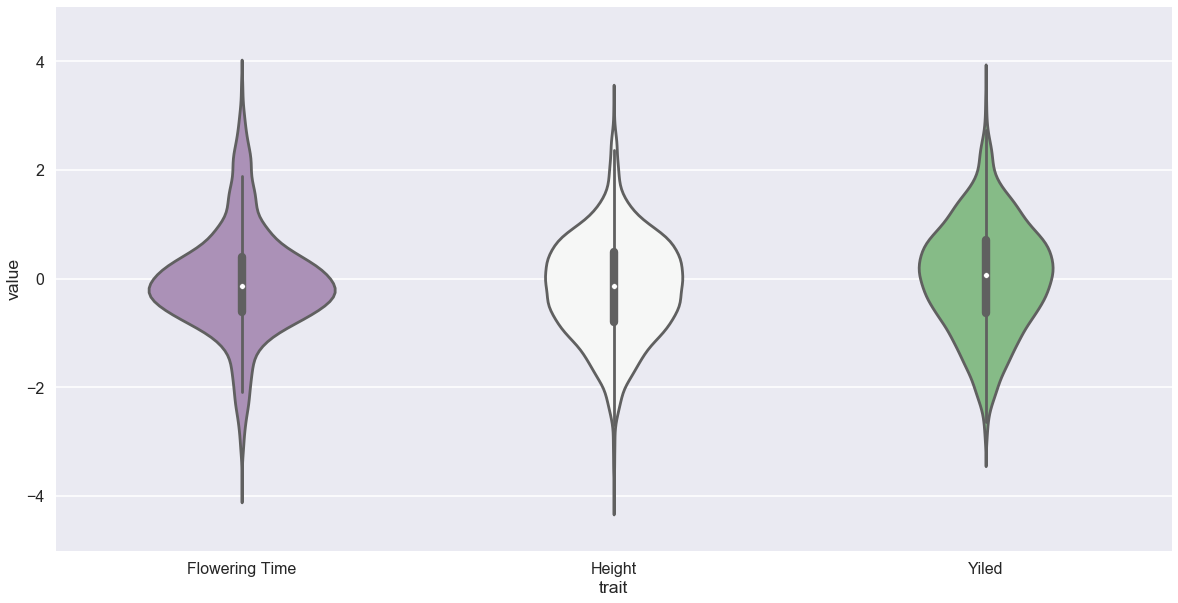

In [20]:
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
def box_plot(styind,contextind,width,height,showbox,fontsize,
               ylim,boxwidth,box_violin):
    sns.set_context(contexts[int(contextind)])
    sns.set_style(styles[int(styind)])

    fig, ax = plt.subplots(figsize=(width,height))
    if showbox =='yes':
        if box_violin=='violin':
            sns.violinplot(ax=ax,x='trait',y='value',data=phenodatatable, palette="PRGn",width=boxwidth)
        elif box_violin=='box':
            sns.boxplot(ax=ax,x='trait',y='value',data=phenodatatable, palette="PRGn",width=boxwidth)
    ax.set_ylim(ylim)
box_plot(3,2,20,10,'yes',20,
               [-5,5],0.5,'violin')

##### 查看训练集与测试集的划分
下图中彩色部分为训练集性状，白色部分为待预测性状 <br>
可以发现其划分方式并不随机，这会导致常规的机器学习方法出现一些问题，由于是基础介绍，这里不讨论如何解决这个问题。

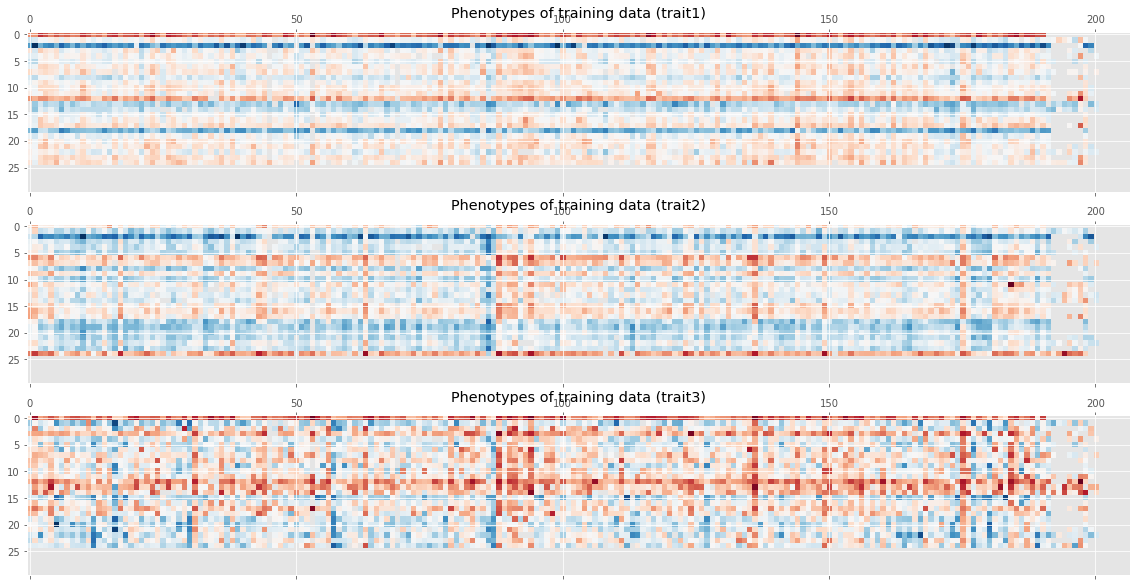

In [8]:
def generate_parent_table(phenotype_file):
    phenotypes = pd.read_table(phenotype_file)
    pedigree = phenotypes['pedigree'].str.split('_', expand=True)
    pedigree.columns = ['f', 'X', 'm']
    phenotypes = pd.concat([phenotypes, pedigree], axis=1)
    phenotypes['number'] = np.arange(phenotypes.shape[0])
    parent_table = phenotypes.pivot_table(values='number'
                                          , index=['m'], columns=['f'], dropna=False)
    male_ids = ['m%d' % i for i in range(1, parent_table.shape[0] + 1)]
    female_ids = ['f%d' % i for i in range(1, parent_table.shape[1] + 1)]
    parent_table = parent_table.loc[male_ids, female_ids]
    return parent_table
phenotype_file = 'data/pheno_emaize.txt'
parent_table = generate_parent_table(phenotype_file)
phenotypes = pd.read_table('data/pheno_emaize.txt')
fig, ax = subplots(3,1, figsize=(20, 10))
for i in range(3):
    trait = ['trait1','trait2','trait3'][i]
    ax[i].matshow(np.take(np.ravel(phenotypes[trait].values), parent_table), cmap=cm.RdBu)
    ax[i].set_title('Phenotypes of training data (%s)'%trait)

###  2将SNP数据编码为向量
每个位点的碱基只有三种情况，不会出现更多碱基组合的可能，比如某位点仅有AA，AT，TT三种可能的情况<br>
我们可以采取三种方式对其编码：
- 转化为0、1、2。找到minor allele frequency（MAF），即两种碱基（如A、T）中出现频率低的那个，以A作为MAF为例，则TT为0，AT为1，AA为2，这样可以突出MAF
- 转化为3-bit one hot vector,$[1,0,0]^T,[0,1,0]^T,[0,0,1]^T$这样可以保持三种向量在空间距离的一致
- 转化为2-bit vector,则AA，AT，TT分别编为$[1,0]^T,[1,1]^T,[0,1]^T$,不需要考虑MAF
我们采取第三种方式

In [9]:
def convert_2bit(seq):
    genotypes = np.zeros([6210,2])
    a = seq[1].split('/')
    for i in range(6210):
        if seq[4:][i] == a[0] + a[0]:
            genotypes[i] = np.array([0,1])
        if seq[4:][i] == a[0] + a[1]:
            genotypes[i] = np.array([1,0])
        if seq[4:][i] == a[1] + a[1]:
            genotypes[i] = np.array([1,1])
    genotypes = genotypes.astype('int').T
    return genotypes

**注意，接下来的步骤耗时较长** <br>
**可以跳过接下来的代码框步骤，直接使用处理好的结果，data/2bit_geno** <br>
真实完成此步骤使用了C加速计算，这里为了连贯性仅仅展示python的方法 

In [13]:
#该代码框可跳过以节约时间，直接运行下一个代码框
geno_conv = convert_2bit(snps[1])
for i in tqdm(range(4999)):
    geno_conv = np.concatenate((geno_conv,convert_2bit(snps[i+2])),axis =0)

HBox(children=(IntProgress(value=0, max=4999), HTML(value=u'')))

In [15]:
#读取处理成2bit格式的SNP
with h5py.File('data/2bit_geno') as f:
    geno_conv = f['data'][:]

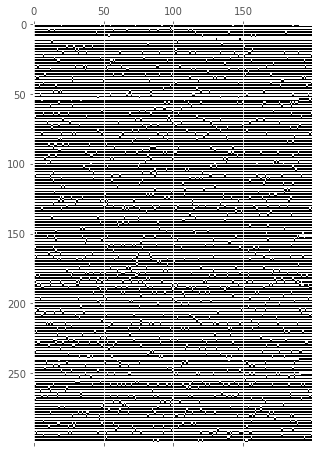

In [16]:
#查看SNP的大致情况
fig, ax = plt.subplots(figsize=(5,10))
ax.matshow(geno_conv[:300,:200],cmap = cm.binary_r)

### 3特征提取与降维
原数据每个样本有190万个SNP，转化为2bit coding后有大约380万个feature，大多数的feature可能是冗余的 <br>
而且过多的feature使得机器学习模型无法承受，一个考虑时间开销及效果的feature数量应该在几千至几万量级 <br>
#### 特征选择：
特征选择的方法包括filter，wrapper和embedding三大类 <br>
我们使用过如下方法： <br>
Mutual information:劣势在于需要将连续的性状值离散化，损失信息<br>
ANOVA:通过p-value筛选feature，速度较慢，我们设计了加速ANOVA计算的算法。<br>
基于模型的方法:基于广义线性模型或其他带有feature权重的机器学习模型，根据权重挑选feature<br>

#### 降维：
PCA、SVD：劣势在于降维后的feature数量不能超过样本数量，一次性损失的feature过多<br>
Random projection:基于LSH的降维方式，速度较快<br>

通过对问题的后续分析，我们发现对于预测绝大多数样本，基本的降维方法就已经够用<br>
但是对于部分很难预测的样本，简单的特征选择方法也无法取得好的效果<br>
我们根据后续开发的针对性的模型，设计了基于模型的特征选择方法，因为内容限制，不在这里使用。

#### 接下来分别使用ANOVA和  Random projection演示特征选择和降维，对于后续的计算来说，选择其中一种就可以，也可以把不同的方法拼起来使用

#### 我们会提供ANOVA、Random projection处理上面5000个snps后的数据，以及在完整数据集上用Random projection降维至10000个feature的数据。用于送入下一部分的回归模型。下面的三种方法的处理后的数据可以在feature_selection文件夹下找到，存储格式为HDF5，用h5py打开
- **ANOVA数据**： 

**数据存放位置**：feature_selection/anova    

包含三个性状各自的feature，大小为4000*6210
- **Random projection(5000)数据**：   

**数据存放位置**：feature_selection/randomproj_5000    

从5000个SNPs降维得到，三个性状使用同一组feature,大小为1000*6210
- **Random projection(whole SNPs)数据**： 

**数据存放位置**：feature_selection/randomproj_whole 

从所有SNPs降维得到，三个性状使用同一组feature，大小为10000*6210

#### ANOVA
方差分析方法可以利用p值挑选feature <br>
调用scipy.stats.f_oneway,利用SNPs和性状可以很容易地计算出p-value，但是对于大量数据来说速度较慢 <br>
这里我们使用一种**加速ANOVA**计算的方法完成计算，相比于**scipy.stats**的方法可以提升计算速度数百倍。

In [17]:
#加速ANOVA算法
def fast_anova_2bit(X, y):
    y = y - y.mean()
    y2 = y*y
    N = X.shape[0]
    SS_tot = np.sum(y2)
    # 10, 01, 11
    masks = [np.logical_and(X[:, 0::2], np.logical_not(X[:, 1::2])),
             np.logical_and(np.logical_not(X[:, 0::2]), X[:, 1::2]),
             np.logical_and(X[:, 0::2], X[:, 1::2])]
    Ni = np.concatenate([np.sum(mask, axis=0) for mask in masks]).reshape((3, -1))
    at_least_one = Ni > 0
    SS_bn = [np.sum(y.reshape((-1, 1))*mask, axis=0) for mask in masks]
    SS_bn = np.concatenate(SS_bn).reshape((3, -1))
    SS_bn **= 2
    SS_bn = np.where(at_least_one, SS_bn/Ni, 0)
    SS_bn = np.sum(SS_bn, axis=0)
    SS_wn = SS_tot - SS_bn
    M = np.sum(at_least_one, axis=0)
    DF_bn = M - 1
    DF_wn = N - M
    SS_bn /= DF_bn
    SS_wn /= DF_wn
    F = SS_bn/SS_wn
    
    p_vals = np.ones(F.shape[0])
    ind = np.nonzero(M == 2)[0]
    if ind.shape[0] > 0:
        p_vals[ind] = scipy.stats.f.sf(F[ind], 1, N - 2)
    ind = np.nonzero(M == 3)[0]
    if ind.shape[0] > 0:
        p_vals[ind] = scipy.stats.f.sf(F[ind], 2, N - 3)
    return F, p_vals

##### 注意X和y分别是什么
我们需要输入进 fast_anova_2bit(X, y)的X是处理过的SNPs中前4754个样本的，y是trait1、trait2、trait3
因为需要分别预测三个性状，我们需要针对三个性状分别挑选特征

In [18]:
geno_conv_train = geno_conv[:,:4754]
geno_conv_test = geno_conv[:,4754:]
print (geno_conv_train.shape)
print (geno_conv_test.shape)

(10000, 4754)
(10000, 1456)


In [19]:
#分别计算三种性状下5000个SNPs做完ANOVA的p-value
F,pval_1 = fast_anova_2bit(geno_conv_train.T,trait1)
F,pval_2 = fast_anova_2bit(geno_conv_train.T,trait2)
F,pval_3 = fast_anova_2bit(geno_conv_train.T,trait3)
pval_1.shape

(5000,)

Text(0.5,1,u'5000 SNPs p-value for trait3 distribution')

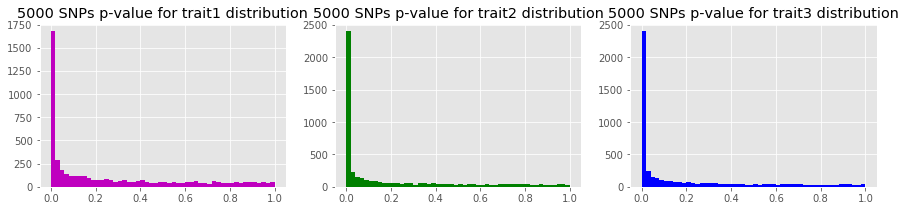

In [22]:
fig, ax = plt.subplots(1,3, figsize=(15,3))
ax[0].hist(pval_1,bins = 50,color='m')
ax[0].set_title('5000 SNPs p-value for trait1 distribution')
ax[1].hist(pval_2,bins = 50,color='g')
ax[1].set_title('5000 SNPs p-value for trait2 distribution')               
ax[2].hist(pval_3,bins = 50,color='b')
ax[2].set_title('5000 SNPs p-value for trait3 distribution')

可以设定一个阈值，比如留下p-value前百分之四十的SNPs <br>
根据index选取留下的SNPs

In [23]:
threshold1 = np.percentile(pval_1,40)
threshold2 = np.percentile(pval_2,40)
threshold3 = np.percentile(pval_3,40)
print ('threshold1: %f' %threshold1)
print ('threshold2: %f' %threshold2)
print ('threshold3: %f' %threshold3)

threshold1: 0.044328
threshold2: 0.004042
threshold3: 0.004392


In [24]:
#返回符合条件的p-value的坐标，即可找到需要留下的SNPs的位置，注意每个SNPs占据两行
anova_index_1 = np.where(pval_1<threshold1)[0]
anova_index_1 = np.sort(np.concatenate((anova_index_1,anova_index_1 +1)))
anova_index_2 = np.where(pval_2<threshold2)[0]
anova_index_2 = np.sort(np.concatenate((anova_index_2,anova_index_2 +1)))
anova_index_3 = np.where(pval_3<threshold3)[0]
anova_index_3 = np.sort(np.concatenate((anova_index_3,anova_index_3 +1)))

In [25]:
#根据p-value选取保留的SNPs，注意这一步要在所有的6210个样本上做
feature1_anova = np.take(geno_conv,anova_index_1,axis=0)
feature2_anova = np.take(geno_conv,anova_index_2,axis=0)
feature3_anova = np.take(geno_conv,anova_index_3,axis=0)

feature*_anova 即为回归模型可以使用的feature

#### Random projection
Random projection 不依赖于性状，仅仅在原SNPs数据进行降维 <br>
Random projection可以使用scikit-learn下的sklearn.random_projection模块计算 <br>
包括generate，transform和normalize等步骤 <br>
这里演示从5000个feature（10000行）降维

- generate
产生一个稀疏矩阵

In [26]:
#10000为操作前的feature个数：2*5000
X = np.zeros((2, 10000))
#确定降维后的个数，这里定为1000，使用sklearn random_projection 模块下的 SparseRandomProjection 函数
proj = SparseRandomProjection(1000)
proj.fit(X)
print (proj.components_.shape)

(1000, 10000)


- transform

In [27]:
X= geno_conv.T
X_ = proj.transform(X)

- normalize
对每个feature进行normalize，避免出现过大的值

In [28]:
from sklearn.preprocessing import StandardScaler
normalized_feeature = StandardScaler().fit_transform(X_).T

最终大小为1000*6210，结果在feature_selection/randomproj_5000

### 4回归模型
这部分通过几个常用的机器学习模型对上一部处理过的feature进行拟合和预测
这里使用sklearn和xgboost提供的模块，这些模块具有很好的封装，使用风格统一，使用时可以查看其官方文档
这里不介绍具体的机器学习模型的算法原理，可以参考周志华老师的《机器学习》等书进行学习。

#### 机器学习模型
接下来会使用一些常用的可以用于回归的机器学习模型，可以选择其中的一种或几种对feature_selection/文件夹下的三种数据进行回归和预测。下面我们将几个模型列出，并且选择其中的一种作为示例，其他的模型可同理调用。 <br>
我们使用$r^2,pcc$作为衡量预测结果的指标<br>
$$\mathbf{r^2} = 1-\frac{SS_{res}}{SS_{tot}}$$<br>
$$\mathbf{pcc} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y} $$<br>
我们可以绘制结果的heatmap图，散点图等进行可视化。

#### 交叉验证
交叉验证(Cross validation)可以帮助调参，寻找机器学习模型中的超参数 <br>
一般可以使用10折或者5折交叉验证，注意在最终预测时，使用调参后的模型在整个训练集上训练，这时不再交叉验证 <br>
因为交叉验证需要额外增加计算时间，因此这里只在整个训练集上训练一次，不再展示交叉验证的过程。

**如果深究的话，本问题还有其特殊性，可以设计特殊的交叉验证方式** <br>
不同的样本具有关联性CV，有的样本可能来自同一亲本，而且训练集和测试集的划分并不是随机的
因此在真正解决这个问题的时候，需要考虑不同的抽样方式下的调参与训练，我们可以使用下图所示的几种抽样方式

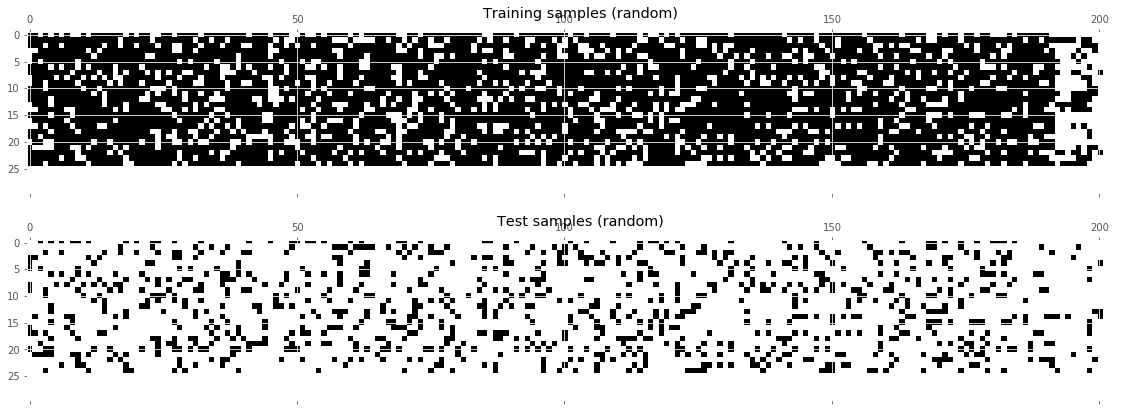

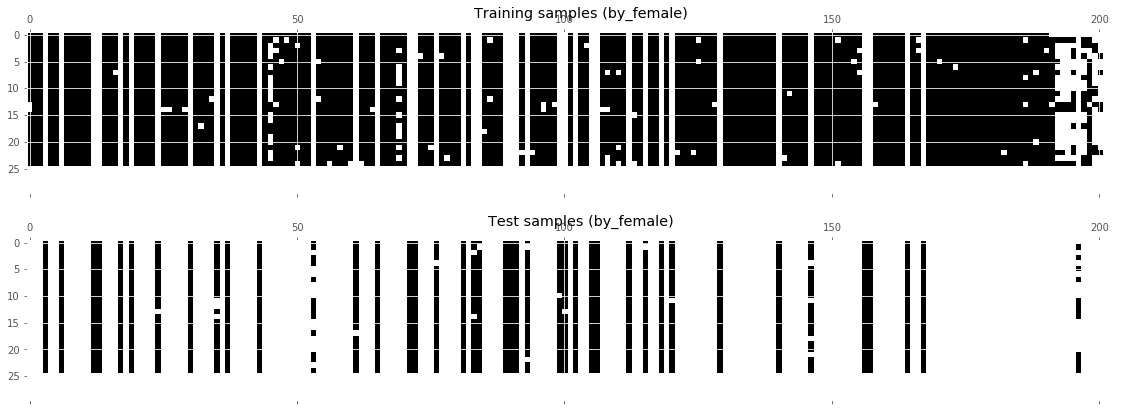

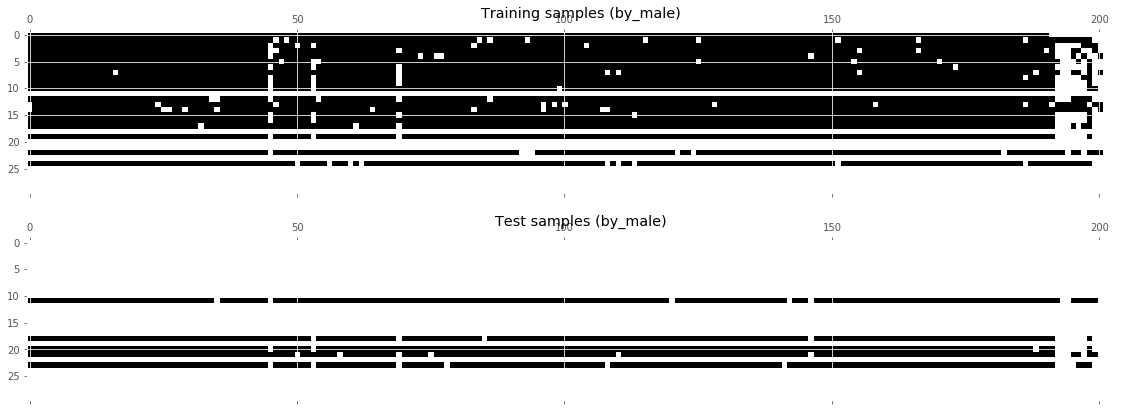

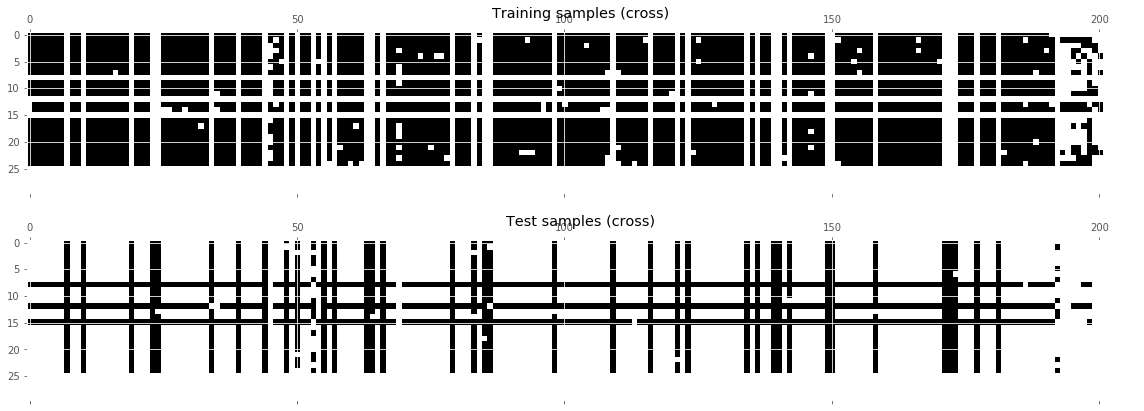

In [29]:
for method in ('random', 'by_female', 'by_male', 'cross'):
    with h5py.File('data/cv_index.%s'%method, 'r') as f:
        index_train = f['0/train'][:]
        index_test = f['0/test'][:]
    fig, ax = subplots(2, 1, figsize=(16, 6))
    sampling_table = np.zeros(np.prod(parent_table.shape))
    sampling_table[index_train] = 1
    sampling_table = np.take(sampling_table, parent_table)
    ax[0].matshow(sampling_table, cmap=cm.Greys)
    ax[0].set_title('Training samples (%s)'%method)

    sampling_table = np.zeros(np.prod(parent_table.shape))
    sampling_table[index_test] = 1
    sampling_table = np.take(sampling_table, parent_table)
    ax[1].matshow(sampling_table, cmap=cm.Greys)
    ax[1].set_title('Test samples (%s)'%method)
    plt.tight_layout()

#### 准备数据
sklearn的机器学习模型一般需要提供X和y以供模型训练，然后提供新的X，模型就可以预测新的y <br>
通过前面的工作，我们获得了三种不同的X(ANOVA、random projection(5000/whole))，我们还需要将X和y划分为训练集和测试集 <br>
注意我们需要分别对三个性状进行预测，因此ANOVA的X是三种  <br>
**评价模型的时候要注意，y_true的部分值缺失**

先处理y，y 的train和test是统一的，不受方法影响

In [30]:
#y 的train和test的统一的，不受方法影响
pheno_whole = pd.read_csv('data/emaize_pheno_whole',delimiter=',')
wholepheno = {}
for trait in ['trait1','trait2','trait3']:
    wholepheno[trait] = np.array(pheno_whole[trait])
y_train = {}
y_test = {}
for trait in ['trait1','trait2','trait3']:
    y_train[trait] = wholepheno[trait][:4754]
    y_test[trait] = wholepheno[trait][4754:]

再处理X，
- 使用ANOVA时X要区分不同性状，Random projection由于是与性状无关的降维方法，三种性状下的feature都一样 <br>
- 因为机器学习模型要求一般数据形式为sample*feature，因此需要对矩阵转置

In [31]:
def prepare_data(method):
    if method == 'randomproj_5000':
        with h5py.File('feature_selection/randomproj_5000') as f:
            X_train = f['data'][:][:,:4754].T
            X_test = f['data'][:][:,4754:].T
    if method == 'randomproj_whole':
        with h5py.File('feature_selection/randomproj_whole') as f:
            X_train = f['X'][:][:4754,:]
            X_test = f['X'][:][4754:,:]
    if method == 'anova':
        X_train = {}
        X_test = {}
        with h5py.File('feature_selection/anova') as f:
            X_train['trait1'] = f['feature1'][:][:,:4754].T
            X_test['trait1'] = f['feature1'][:][:,4754:].T
            X_train['trait2'] = f['feature2'][:][:,:4754].T
            X_test['trait2'] = f['feature2'][:][:,4754:].T
            X_train['trait3'] = f['feature3'][:][:,:4754].T
            X_test['trait3'] = f['feature3'][:][:,4754:].T
    return X_train,X_test

选择三种方法之一作为X,注意ANOVA方法返回的X需要指明性状

- 查看anova方法产生的X_train X_test

In [32]:
X_train, X_test = prepare_data('anova')
print ('anova method X_train shape: %s' %X_train['trait1'].shape)
print ('anova method X_test shape: %s' %X_test['trait1'].shape)

anova method X_train shape: (4754, 4000)
anova method X_test shape: (1456, 4000)


- 查看random projection方法产生的X_train X_test

In [34]:
X_train, X_test = prepare_data('randomproj_5000')
print ('random projection method X_train shape: %s' %X_train.shape)
print ('random projection method X_test shape: %s' %X_test.shape)

random projection method X_train shape: (4754, 1000)
random projection method X_test shape: (1456, 1000)


#### 选择需要的机器学习模型
接下来会提供多种机器学习模型，并且讲解其使用方法，可以选择自己喜欢的模型进行回归，也可以用sklearn或其他package提供的模型
模型包括：
- lr: Linear regression
- ridge: Ridge regression
- kr: Kernel Ridge regression
- rfr: Random Forest regression
- xgbr: XGBoost regression
- knr: K-nearest neigbour regression
- gpr: Gaussian Process regression

In [35]:
def Model(model):
    if model=='lr':
        reg = LinearRegression()
    elif model=='xgbr':
        reg = XGBRegressor()
    elif model=='ridge':
        reg = Ridge()
    elif model=='kr':
        reg = KernelRidge(alpha = 10000, kernel = 'polynomial',degree = 3)
    elif model=='knr':
        reg = neighbors.KNeighborsRegressor(n_neighbors=4, algorithm='brute')
    elif model=='rfr':
        reg = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=12, n_jobs=5)
    elif model=='gpr':
        kernel = 1.0 * DotProduct(sigma_0=1.0)**4
        reg = GaussianProcessRegressor(kernel = kernel, optimizer=None)
    return reg

接下来可以使用三种特征（X）中的一种以及七种方法中的一种进行训练和预测 <br>
这里我们以randomproj_5000作为特征，用Ridge作为回归模型演示 <br>
如果用anova得到的feature，需要注意不同性状的feature不一样 <br>
某个机器学习模型的使用方法如下：reg.fit(X,y)用于拟合，reg.predict(X)用于预测。更多用法可以参考sklearn官方文档

In [36]:
X_train, X_test = prepare_data('randomproj_whole')
reg = Model('gpr')
y_predict = {}
y_predict_train = {}
for trait in tqdm(['trait1','trait2','trait3']):
    reg.fit(X_train,y_train[trait])
    y_predict[trait] = reg.predict(X_test)
    y_predict_train[trait] = reg.predict(X_train)

HBox(children=(IntProgress(value=0, max=3), HTML(value=u'')))

计算预测结果与真实值的$r^2,PCC$

In [37]:
test_nonan = np.where(np.isnan(np.array(pheno_whole['trait1'])[4754:]) ==0) # 返回非零元素的索引
pcc_train = {}
pcc_test = {}
r2_train = {}
r2_test = {}
for trait in ['trait1','trait2','trait3']:
    pcc_test[trait] = pearsonr(y_predict[trait][test_nonan],np.array(pheno_whole[trait])[4754:][test_nonan])
    pcc_train[trait] = pearsonr(y_predict_train[trait],y_train[trait])
    r2_test[trait] = r2_score(y_predict[trait][test_nonan],np.array(pheno_whole[trait])[4754:][test_nonan])
    r2_train[trait] = r2_score(y_predict_train[trait],y_train[trait])

In [38]:
pcc_test

{'trait1': (0.4315463415180867, 4.399156293540735e-50),
 'trait2': (0.46160955172706764, 6.054381352397026e-58),
 'trait3': (0.5632473566880299, 3.5568566668991143e-91)}

In [39]:
pcc_train

{'trait1': (1.0, 0.0), 'trait2': (1.0, 0.0), 'trait3': (1.0, 0.0)}

In [40]:
r2_test

{'trait1': -8.19605629823229,
 'trait2': -7.46240929862646,
 'trait3': -1.991198872635442}

In [41]:
r2_train

{'trait1': 1.0, 'trait2': 1.0, 'trait3': 1.0}

可以看到预测结果并不是很好，在测试集上的pcc只有0.5左右。后续的分析可以发现，这是因为样本之间具有相关性导致的<br>
具体的原因分析比较复杂，简单来说，因为这组测试集与训练集的样本的亲本之间亲缘关系较远，模型难以从SNPs得到的feature推断出亲本信息，导致预测结果较差。

绘制heatmap图观察预测结果 <br>
GPR具有很强的拟合能力，总可以在**训练集**上得到接近1的PCC

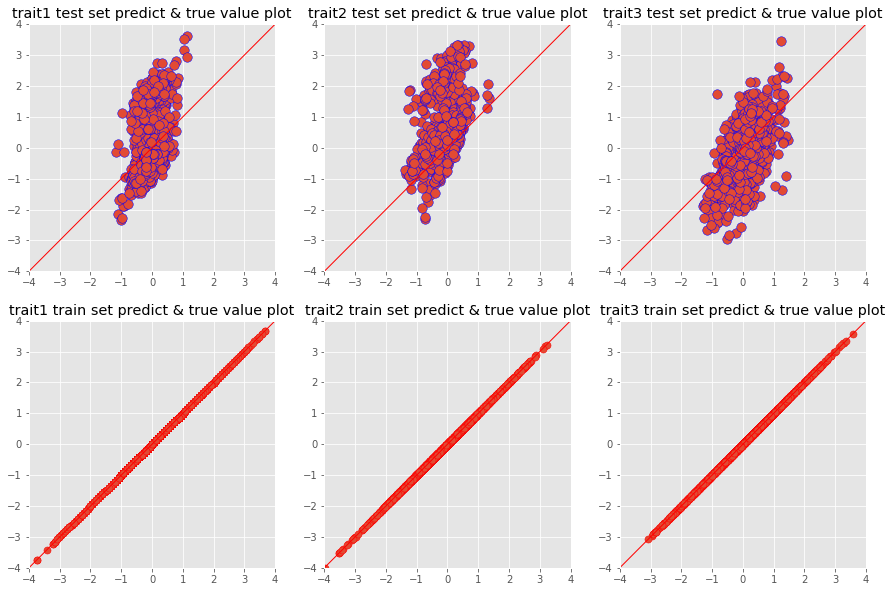

In [48]:
fig, ax = plt.subplots(2,3, figsize=(15,10))
for i in range(3):
    traits = ['trait1','trait2','trait3']
    ax[0,i].scatter(y_predict[traits[i]][test_nonan],np.array(pheno_whole[traits[i]])[4754:][test_nonan],edgecolors='b',cmap=plt.cm.coolwarm,s=90)
    ax[0,i].set_title('%s test set predict & true value plot' %traits[i])
    line1 = [(-4, -4), (4, 4)]
    (line1_xs, line1_ys) = zip(*line1)
    ax[0,i].add_line(Line2D(line1_xs, line1_ys, linewidth=1, color='red'))
    ax[0,i].set_xlim(left=-4, right=4)
    ax[0,i].set_ylim(bottom=-4, top=4)
    ax[1,i].scatter(y_predict_train[traits[i]],y_train[traits[i]],edgecolors='r',cmap=plt.cm.coolwarm,s=50)
    ax[1,i].set_title('%s train set predict & true value plot' %traits[i])
    ax[1,i].add_line(Line2D(line1_xs, line1_ys, linewidth=1, color='red'))
    ax[1,i].set_xlim(left=-4, right=4)
    ax[1,i].set_ylim(bottom=-4, top=4)

绘制完整真实值与预测值的heatmap图 <br>
从图中我们可以清晰地看出一个基本的模型的问题： <br>
模型强烈地依赖已有信息进行预测，当未知样本的父本与已知训练集的亲缘关系较远时，模型只能依赖母本（横坐标）进行预测 <br>
导致预测的heatmap图有明显的与母本相关的特征，而实际上子代的性状更容易被父本主导 <br>

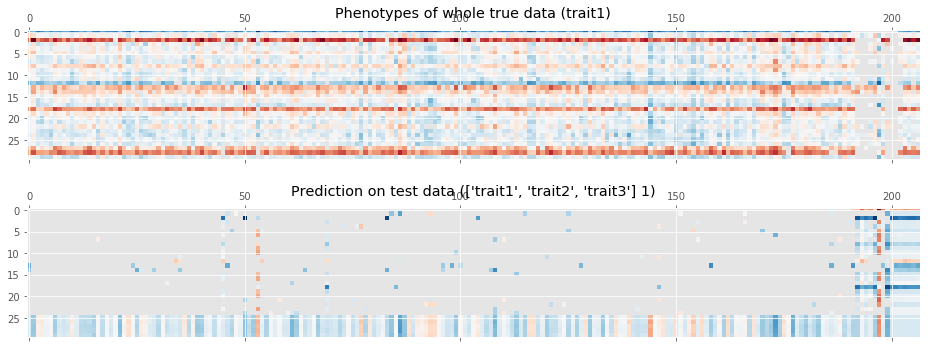

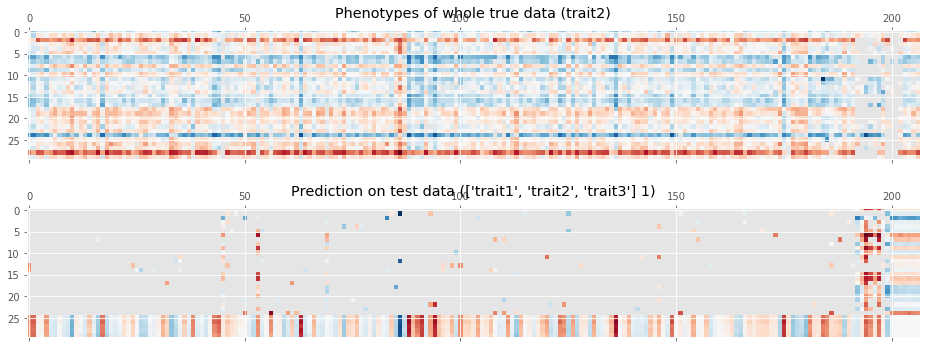

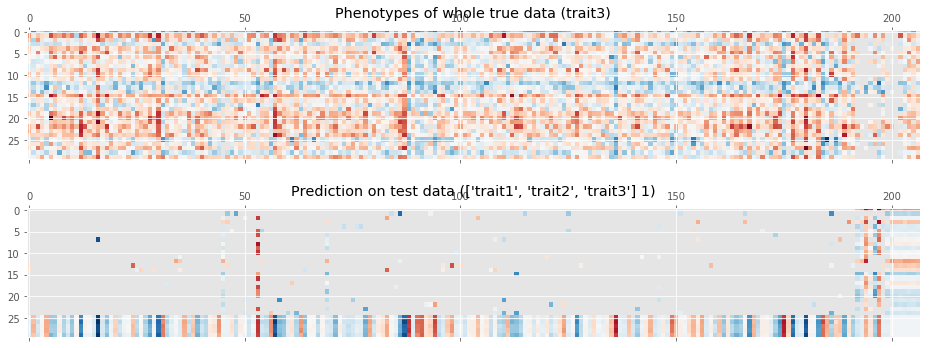

In [49]:
wholepre = np.concatenate((y_predict['trait1'],y_predict['trait2'],y_predict['trait3'])).reshape(3,-1)
predictions =  pd.DataFrame(wholepre.T)
predictions.columns = ['trait1', 'trait2', 'trait3']
predictions = predictions.set_index(np.arange(4754,6210))
def normalize_phenotype(x, range_pheno=4.0):
    return (np.clip(x, -range_pheno, range_pheno) + range_pheno)/2.0/range_pheno
for trait in traits:
    fig, ax = subplots(2, 1, figsize=(16, 6))
    ax[0].matshow(np.take(np.ravel(normalize_phenotype(pheno_whole[trait].values)), parent_table), cmap=cm.RdBu_r)
    ax[0].set_title('Phenotypes of whole true data (%s)'%trait)

    trait_pred = np.full(phenotypes.shape[0], np.nan)
    trait_pred[predictions.index.tolist()] = normalize_phenotype(predictions[trait].values)
    ax[1].matshow(np.take(trait_pred, parent_table), cmap=cm.RdBu)
    ax[1].set_title('Prediction on test data (%s 1)'%traits)

### 后续分析
#### 不同样本具有不同的预测难度
普通的机器学习模型在测试集上表现结果不好，但是通过多次的十字交叉抽样模拟，可以发现不同样本的预测难度不同，在大多数样本上，不需要专门设计的机器学习模型就足够表现很好

#### 样本之间具有关联性
不服从一些基本的假设，比如线性模型下，残差并不是独立的，需要考虑问题的特殊性进行额外的设计。<br>
由于存储空间和计算时间的限制，无法展示其他有效的方法，有兴趣的同学可以查找育种领域的其他模型进行尝试。


#### 复杂的机器学习模型并不一定有效
育种领域目前最好的模型依然是线性模型，通过特殊的设计，可以考虑到亲缘关系、显著相关的SNP(causal)以及随机效应部分
而寻找合适的feature是预测结果好坏的决定性因素，至今没有非常好的方法。

我们通过模拟特殊的十字交叉抽样方式发现，虽然测试集的样本不好预测，但是大多数的样本使用简单的机器学习方法就可以在大多数样本上取得较好的结果 <br>
由于计算资源限制，下面直接展示模拟结果

我们使用一种特殊的十字交叉抽样，在训练集上抽样1000次，用来测试基本的机器学习模型结果 <br>
我们使用了2bit coding编码的SNPs,通过random projection降维至80000 <br>
然后使用Gaussian Process Regression作为回归模型 <br>

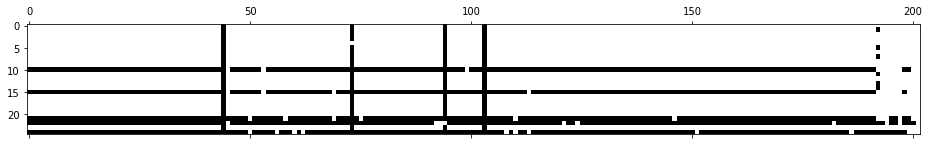

In [50]:
Image(filename='plots/0.png')

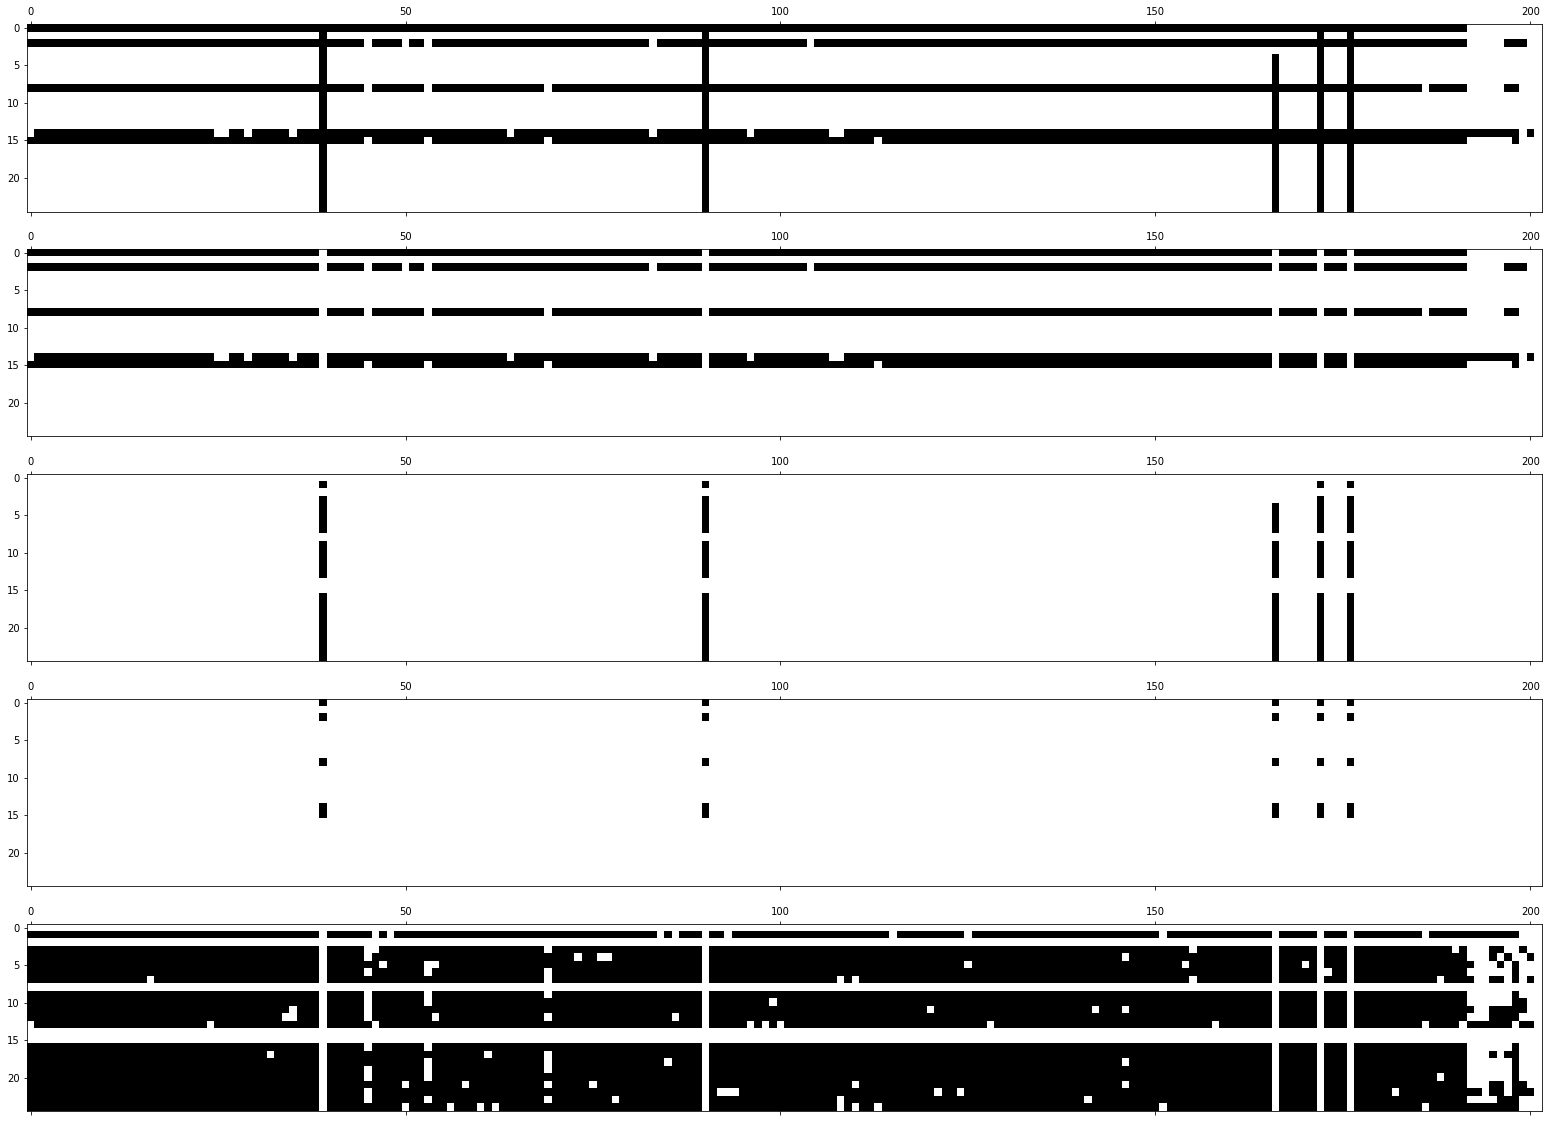

In [51]:
Image(filename='plots/1.png')

可以看到一千次抽样的测试结果，大多数测试的PCC都比较高

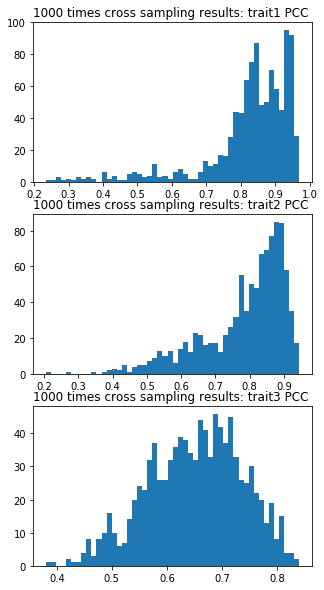

In [52]:
Image(filename='plots/2.png')

按照样本查看每个样本多次抽样的平均PCC，注意这里是有bias没有消除的

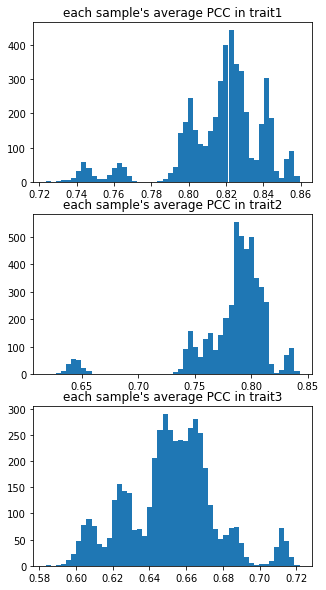

In [53]:
Image(filename='plots/3.png')

这里绘制了每个样本的平均PCC heatmap图像 <br>
可以发现大多数的样本是很好预测的，样本性状基本由父本性状主导（纵坐标为父本） <br>
但是少数亲缘关系较远的父本（图中蓝色线）就很难预测。

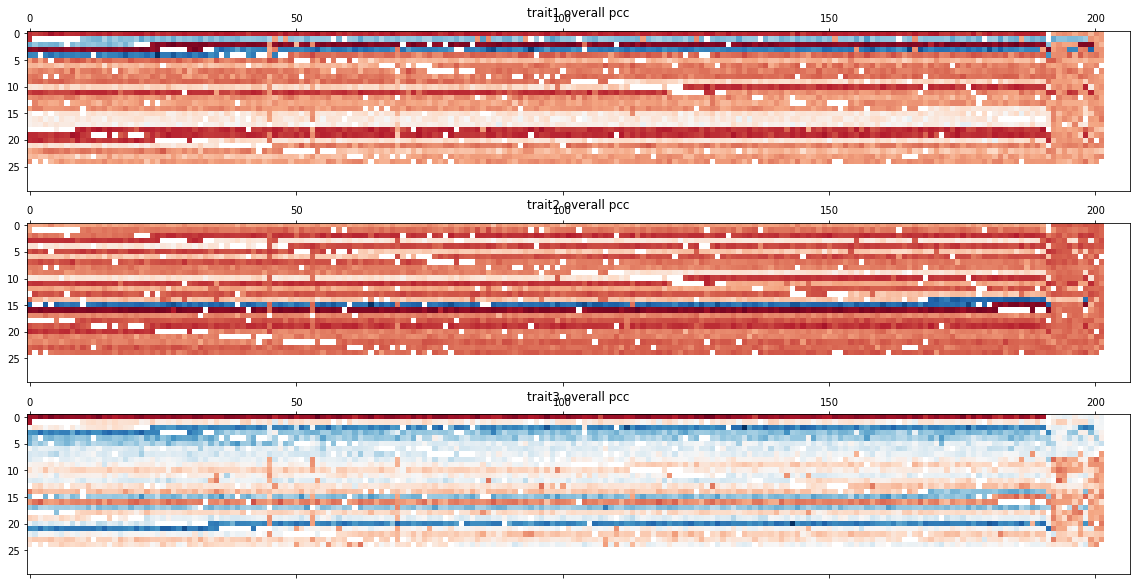

In [54]:
Image(filename='plots/4.png')

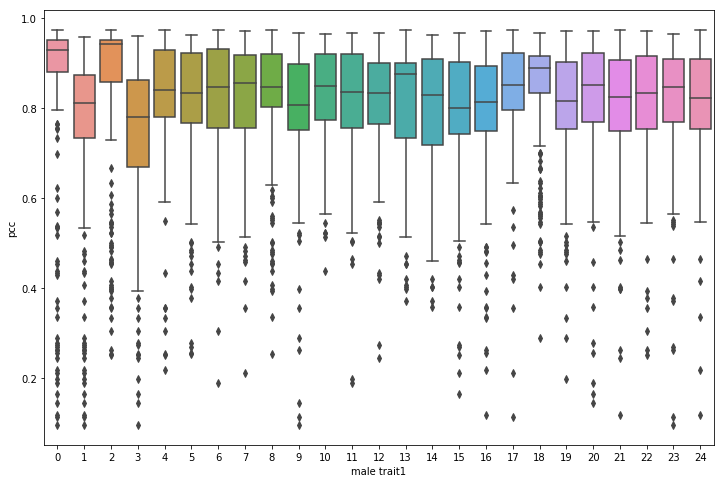

In [55]:
Image(filename='plots/5.png')

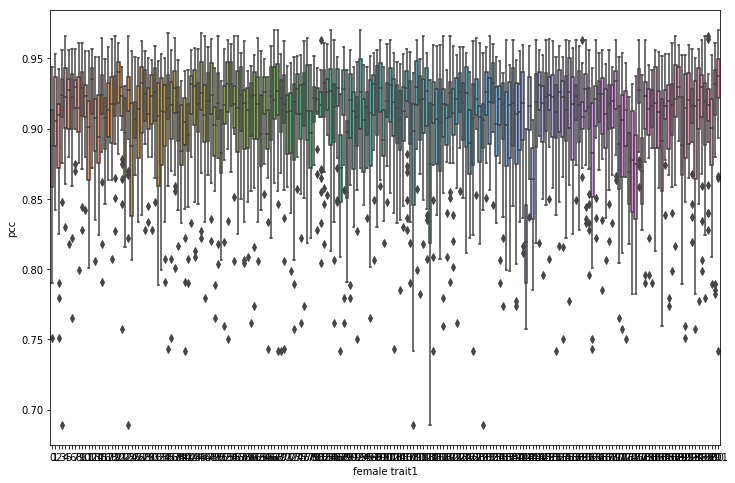

In [56]:
Image(filename='plots/6.png')

不同父本的性状有显著差别，而子代的性状由于设计原因，主要由父本控制。<br>
我们可以通过绘图查看不同父本的性状的变化

Text(0.5,1,u'different males have varied values')

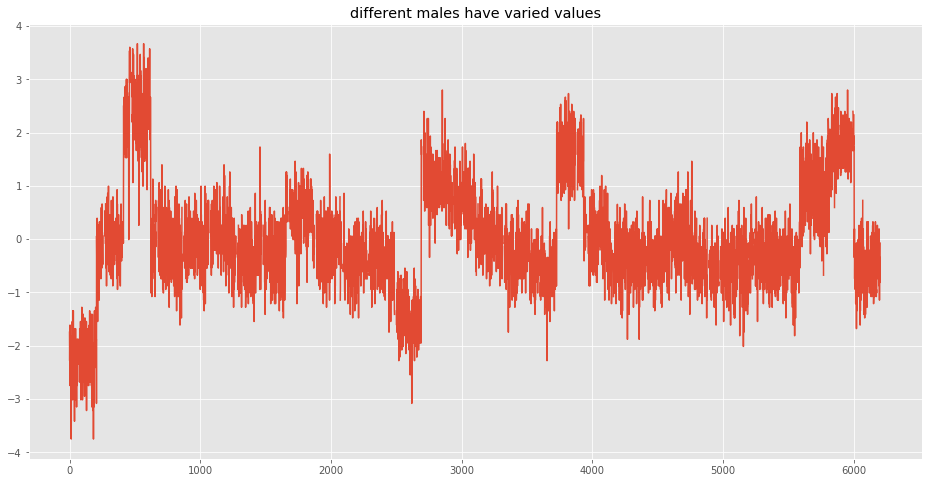

In [57]:
male_index = np.ndarray([6210,]).astype('int')
for i in range(6210):
    male_index[i] = int(np.array(phenotypes['pedigree'])[i].split('_')[2][1:])
male_trait1 = np.concatenate((male_index.reshape(1,-1),np.array(pheno_whole['trait1']).reshape(1,-1))).T
male_trait1_bysort = male_trait1[male_trait1[:,0].argsort()]
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(male_trait1_bysort[:,1])
ax.set_title('different males have varied values')

以上内容简要地介绍了eMaize问题使用的一些基本的常用的机器学习方法，由于实际工作的步骤、数据量、变量等问题，还需要慎重考虑计算时间、任务管理等工作 <br>
想要预测较难预测的样本仅仅靠常规的机器学习方法并不够用，将机器学习应用于生物学问题时，不能简单套用模型，还需要根据问题进行针对性的设计，才有可能取得更好的结果。